
## Trump Sentiment Analysis
Analyzing and draw conclusions about the current US President's tweet behavior using data from the Twitter API.

##### Load Libraries and Setup

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re
import tweepy

In [15]:
# This requires getting your own Twitter developer account and API keys
import json
key_file = '/Users/ajaygoel/Documents/Neu/BigData/Project/keys.json'
# Load my Twitter API auth key from my twitter account
with open(key_file) as f:
    keys = json.load(f)

In [5]:
import tweepy
from tweepy import TweepError
import logging

#ensure my API key is correct
try:
    auth = tweepy.OAuthHandler("4itQ0urqREG2aAJNg6Eyzajgk", "CSXRjWOzEgrG7ClfwLNJcyxmmuLIFPQgWjuk5UNsQi8W6TDZkn")
    auth.set_access_token("2974941042-wO8homuub4QlhSiU4LOdWR2fSjq2V1MTQ3UsxWs", "zaubrsUNIBzsYWaVibCVTAQuAMUJxpXj9DMPEQ963Yifj")
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: c40ed5ef91a645e


In [7]:
from pathlib import Path
import json

ds_tweets_save_path = "BerkeleyData_recent_tweets.json"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have.
    # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
    # This was a change introduced in September 2017.
    
    # The tweepy Cursor API actually returns "sophisticated" Status objects but we 
    # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="Data", 
                                             tweet_mode='extended').items()]
    
    # Saving the tweets to a json file on disk for future analysis
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)

# Re-loading the json file:
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

In [8]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "4itQ0urqREG2aAJNg6Eyzajgk",
                "consumer_secret":  "CSXRjWOzEgrG7ClfwLNJcyxmmuLIFPQgWjuk5UNsQi8W6TDZkn",
                "access_token": "2974941042-wO8homuub4QlhSiU4LOdWR2fSjq2V1MTQ3UsxWs",
                "access_token_secret": "zaubrsUNIBzsYWaVibCVTAQuAMUJxpXj9DMPEQ963Yifj"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    
    with open(path) as f:
        keys = json.load(f)
    return keys

In [9]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "4itQ0urqREG2aAJNg6Eyzajgk",
                "consumer_secret":  "CSXRjWOzEgrG7ClfwLNJcyxmmuLIFPQgWjuk5UNsQi8W6TDZkn",
                "access_token": "2974941042-wO8homuub4QlhSiU4LOdWR2fSjq2V1MTQ3UsxWs",
                "access_token_secret": "zaubrsUNIBzsYWaVibCVTAQuAMUJxpXj9DMPEQ963Yifj"
            }

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""
    import tweepy
    from tweepy import TweepError
    import logging

    try:
        auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
        auth.set_access_token(keys["access_token"], keys["access_token_secret"])
        api = tweepy.API(auth)
        print("Your username is:", api.auth.get_username())
        print("Ready to go...")
    except TweepError as e:
        logging.warning("There was a Tweepy error. Double check your API keys and try again.")
        logging.warning(e)
    
    print("Loading @", user_account_name, "'s data...")
    users_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                             tweet_mode='extended').items()]
    print("Finished!")
    
    return users_tweets

In [10]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    # Saving the tweets to a json file on disk for future analysis
    with open(path, "w") as f:        
        json.dump(tweets, f)

In [11]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    # Re-loading the json file:
    with open(path, "r") as f:
        user_tweets = json.load(f)
    return user_tweets

In [12]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    save_path = user_account_name + "_recent_tweets.json"
    
    if not Path(save_path).is_file():
        keys = load_keys(keys_path)
        user_tweets = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(user_tweets, save_path)
        return user_tweets
    user_tweets = load_tweets(save_path)
    return user_tweets

### Load Donald Trump's Tweets
Should obtain over 3000 of Donald Trumps latest tweets from the past year

In [58]:
# get_tweets_with_cache will load local files of the users tweets if they exist, otherwise download them
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 40


In [19]:
trump_tweets[-1]['created_at']

'Thu Aug 08 14:38:17 +0000 2019'

In [20]:
trump_tweets[1]['created_at']


'Mon Aug 12 04:02:50 +0000 2019'

In [23]:
tweets = {t['id']: t for t in trump_tweets}
#tweets.update({t['id']: t for t in old_trump_tweets})
all_tweets = list(tweets.values())

## Data Cleaning
Here I construct a dataframe to clean out the data I want to use from each tweet

In [24]:
tid = []
time = []
source = []
text = []
retweet_count = []
for tweet in all_tweets: 
    tid.append(tweet['id'])
    time.append(pd.to_datetime(tweet['created_at']))
    source.append(tweet['source'])
    retweet_count.append(tweet['retweet_count'])
    if 'text' in tweet: 
        text.append(tweet['text'])
    else:
        text.append(tweet['full_text'])
trump = pd.DataFrame({'time':time, 'source':source,'text':text,'retweet_count':retweet_count}, 
                    index = tid, columns = ['time', 'source', 'text', 'retweet_count'],).sort_index()
trump.index.name = 'id'

In [25]:
trump['time'] = trump['time'].astype('<M8[ns]')


In [26]:
trump['source'].unique()


array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'],
      dtype=object)

In [27]:
trump['source'] = trump['source'].str.replace(r'<.*?>', '')


In [31]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Mon Aug 12 04:03:51 +0000 2019
Mon Aug 12 04:02:50 +0000 2019
Mon Aug 12 04:01:28 +0000 2019


In [32]:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,est_time
id,,,,,
1159473911748317189,2019-08-08 14:38:17,Twitter for iPhone,"....John Deere, our car companies, &amp; others, to compete on a level playing field. With substantial Fed Cuts (there is no inflation) and no quantitative tightening, the dollar will make it possible for our companies to win against any competition. We have the greatest comp...",14100,2019-08-08 09:38:17-05:00
1159473912616501254,2019-08-08 14:38:17,Twitter for iPhone,"....in the world, there is nobody even close, but unfortunately the same cannot be said about our Federal Reserve. They have called it wrong at every step of the way, and we are still winning. Can you imagine what would happen if they actually called it right?",15229,2019-08-08 09:38:17-05:00
1159522492324687877,2019-08-08 17:51:19,Twitter for iPhone,"Iran is in serious financial trouble. They want desperately to talk to the U.S., but are given mixed signals from all of those purporting to represent us, including President Macron of France....",20390,2019-08-08 12:51:19-05:00
1159522493801123840,2019-08-08 17:51:20,Twitter for iPhone,"....I know Emmanuel means well, as do all others, but nobody speaks for the United States but the United States itself. No one is authorized in any way, shape, or form, to represent us!",18217,2019-08-08 12:51:20-05:00
1159590032514134016,2019-08-08 22:19:42,Twitter for iPhone,"Sue Gordon is a great professional with a long and distinguished career. I have gotten to know Sue over the past 2 years and have developed great respect for her. Sue has announced she will be leaving on August 15, which....",12005,2019-08-08 17:19:42-05:00


In [33]:
hour = trump['est_time'].dt.hour
minutes = trump['est_time'].dt.minute /60
seconds = trump['est_time'].dt.second / 60 **2

trump['hour'] = hour + minutes + seconds

### Sentiment Analysis
It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [34]:
print(''.join(open("/Users/ajaygoel/Documents/Neu/BigData/Project/SentimentAnalysis/vader_lexicon.txt").readlines()[:10]))


$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



In [35]:
sent = pd.read_table("vader_lexicon.txt", sep="\t", header = None, index_col=0)
sent = sent.drop(columns = [2, 3])
sent.index.name = "lexicon"
sent = sent.rename(columns={1:"polarity"})

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [36]:
sent.head()

,polarity
lexicon,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [37]:
trump['text'] = trump['text'].str.lower()


In [38]:
trump['text'].head()


id
1159473911748317189    ....john deere, our car companies, &amp; others, to compete on a level playing field. with substantial fed cuts (there is no inflation) and no quantitative tightening, the dollar will make it possible for our companies to win against any competition. we have the greatest comp...
1159473912616501254                       ....in the world, there is nobody even close, but unfortunately the same cannot be said about our federal reserve. they have called it wrong at every step of the way, and we are still winning. can you imagine what would happen if they actually called it right?
1159522492324687877                                                                                        iran is in serious financial trouble. they want desperately to talk to the u.s., but are given mixed signals from all of those purporting to represent us, including president macron of france....
1159522493801123840                                                                     

In [39]:
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, repl=" ")

In [40]:
tidy_format = trump['no_punc'].str.split(expand=True).stack().reset_index(level=1).rename(columns={"level_1":'num', 0:'word'})

In [41]:
tidy_format.head()

,num,word
id,,
1159473911748317189,0,john
1159473911748317189,1,deere
1159473911748317189,2,our
1159473911748317189,3,car
1159473911748317189,4,companies


In [42]:
polarity = tidy_format.merge(sent, how = 'left', left_on= 'word', right_index=True)
trump['polarity'] = polarity.groupby("id")["polarity"].sum()

In [43]:
trump.head()

,time,source,text,retweet_count,est_time,hour,no_punc,polarity
id,,,,,,,,
1159473911748317189,2019-08-08 14:38:17,Twitter for iPhone,"....john deere, our car companies, &amp; others, to compete on a level playing field. with substantial fed cuts (there is no inflation) and no quantitative tightening, the dollar will make it possible for our companies to win against any competition. we have the greatest comp...",14100,2019-08-08 09:38:17-05:00,9.638056,john deere our car companies amp others to compete on a level playing field with substantial fed cuts there is no inflation and no quantitative tightening the dollar will make it possible for our companies to win against any competition we have the greatest comp...,4.0
1159473912616501254,2019-08-08 14:38:17,Twitter for iPhone,"....in the world, there is nobody even close, but unfortunately the same cannot be said about our federal reserve. they have called it wrong at every step of the way, and we are still winning. can you imagine what would happen if they actually called it right?",15229,2019-08-08 09:38:17-05:00,9.638056,in the world there is nobody even close but unfortunately the same cannot be said about our federal reserve they have called it wrong at every step of the way and we are still winning can you imagine what would happen if they actually called it right,-1.1
1159522492324687877,2019-08-08 17:51:19,Twitter for iPhone,"iran is in serious financial trouble. they want desperately to talk to the u.s., but are given mixed signals from all of those purporting to represent us, including president macron of france....",20390,2019-08-08 12:51:19-05:00,12.855278,iran is in serious financial trouble they want desperately to talk to the u s but are given mixed signals from all of those purporting to represent us including president macron of france,-3.3
1159522493801123840,2019-08-08 17:51:20,Twitter for iPhone,"....i know emmanuel means well, as do all others, but nobody speaks for the united states but the united states itself. no one is authorized in any way, shape, or form, to represent us!",18217,2019-08-08 12:51:20-05:00,12.855556,i know emmanuel means well as do all others but nobody speaks for the united states but the united states itself no one is authorized in any way shape or form to represent us,3.5
1159590032514134016,2019-08-08 22:19:42,Twitter for iPhone,"sue gordon is a great professional with a long and distinguished career. i have gotten to know sue over the past 2 years and have developed great respect for her. sue has announced she will be leaving on august 15, which....",12005,2019-08-08 17:19:42-05:00,17.328333,sue gordon is a great professional with a long and distinguished career i have gotten to know sue over the past 2 years and have developed great respect for her sue has announced she will be leaving on august 15 which,8.3


In [44]:
#Trumps most negative tweets
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   ....to inflame and cause chaos. they create their own violence, and then try to blame others. they are the true racists, and are very bad for our country!

   rt @w_terrence: died of suicide on 24/7 suicide watch ? yeah right! how does that happen

#jefferyepstein had information on bill clinton &amp;…

   maggie haberman of the failing @nytimes reported that i was annoyed by the lack of cameras inside the hospitals in dayton &amp; el paso, when in fact i was the one who stated, very strongly, that i didn’t want the fake news inside &amp; told my people not to let them in. fake reporting!

   ..tv talent. then, during the 2016 election, i would watch as joe scarborough &amp; his very angry psycho wife(?) would push donny to the point of total humiliation. he would never fight back because he wanted to stay on tv, even on a very low rated show, all in the name of ambition!

   never has the press been more inaccurate, unfair or corrupt! we are not fighting the 

In [45]:

#Trumps most positive Tweets
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   i am pleased to inform you that the honorable joseph maguire, current director of the national counterterrorism center, will be named acting director of national intelligence, effective august 15th. admiral maguire has a long and distinguished....

   sue gordon is a great professional with a long and distinguished career. i have gotten to know sue over the past 2 years and have developed great respect for her. sue has announced she will be leaving on august 15, which....

   many incredible things are happening right now for our country. after years of being ripped off by other nations on both trade deals and the military, things are changing fast. big progress is being made. america is respected again. keep america great!

   china wants to make a deal so badly. thousands of companies are leaving because of the tariffs, they must stem the flow. at the same time china may be hoping for a democrat to win so they could continue the great ripoff of america, &amp

//anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


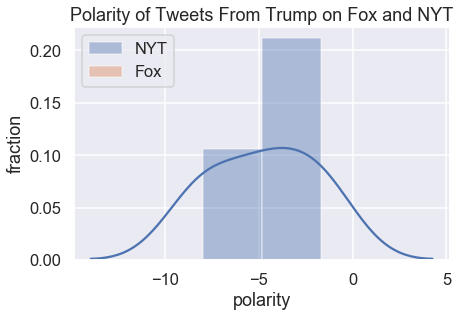

In [46]:
nyt = trump[trump["no_punc"].str.contains('nyt')]['polarity']
fox =  trump[trump["no_punc"].str.contains('fox')]['polarity']

sns.distplot(trump.loc[nyt.index.values]["polarity"], label = "NYT")
sns.distplot(trump.loc[fox.index.values]["polarity"], label = "Fox") 
plt.ylabel("fraction")
plt.legend()
plt.title("Polarity of Tweets From Trump on Fox and NYT")
plt.show()